In [2]:
import pandas as pd

path = 'complete_daily_revenue_totals.csv'
df = pd.read_csv(path, parse_dates=['Date'])

In [5]:
df.head(10)

,Date,MealPeriod,RevenueCenterName,TotalCheckAmount
0,2023-01-01,BreakFast,RevenueCenter_1,1499.4
1,2023-01-01,BreakFast,RevenueCenter_2,35.0
2,2023-01-01,BreakFast,RevenueCenter_3,0.0
3,2023-01-01,BreakFast,RevenueCenter_4,0.0
4,2023-01-01,BreakFast,RevenueCenter_5,21807.0
5,2023-01-01,BreakFast,RevenueCenter_6,93.0
6,2023-01-01,BreakFast,RevenueCenter_7,0.0
7,2023-01-01,BreakFast,RevenueCenter_8,0.0
8,2023-01-01,BreakFast,RevenueCenter_9,0.0
9,2023-01-01,Dinner,RevenueCenter_1,4374.5


In [7]:
import pandas as pd
import itertools

# Step 1: Get all unique values
all_dates = df["Date"].unique()
all_meals = df["MealPeriod"].unique()
all_centers = df["RevenueCenterName"].unique()

# Step 2: Create full cartesian product of all combinations
all_combinations = pd.DataFrame(
    list(itertools.product(all_dates, all_meals, all_centers)),
    columns=["Date", "MealPeriod", "RevenueCenterName"]
)

# Step 3: Group actual data
actual_totals = (
    df.groupby(["Date", "MealPeriod", "RevenueCenterName"])
    .sum()
    .reset_index()
    .rename(columns={"CheckTotal": "TotalCheckAmount"})
)

# Step 4: Merge with full combinations and fill missing with 0
final_df = (
    all_combinations
    .merge(actual_totals, on=["Date", "MealPeriod", "RevenueCenterName"], how="left")
    .fillna({"TotalCheckAmount": 0})
    .sort_values(by=["Date", "MealPeriod", "RevenueCenterName"])
)

# Step 5: Save to CSV
final_df.to_csv("complete_daily_revenue_totals.csv", index=False)

final_df.head()

,Date,MealPeriod,RevenueCenterName,TotalCheckAmount
0,2023-01-01,BreakFast,RevenueCenter_1,1499.4
1,2023-01-01,BreakFast,RevenueCenter_2,35.0
2,2023-01-01,BreakFast,RevenueCenter_3,0.0
3,2023-01-01,BreakFast,RevenueCenter_4,0.0
4,2023-01-01,BreakFast,RevenueCenter_5,21807.0


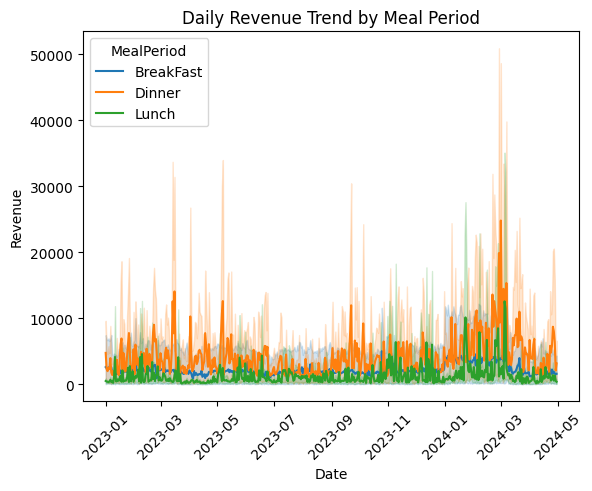

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a line plot with 'Date' on the x-axis and 'TotalCheckAmount' on the y-axis
# Different lines are colored by 'MealPeriod'
sns.lineplot(data=final_df, x="Date", y="TotalCheckAmount", hue="MealPeriod")

# Set the title of the plot
plt.title("Daily Revenue Trend by Meal Period")

# Label the y-axis as 'Revenue'
plt.ylabel("Revenue")

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45)

# Display the plot
plt.show()


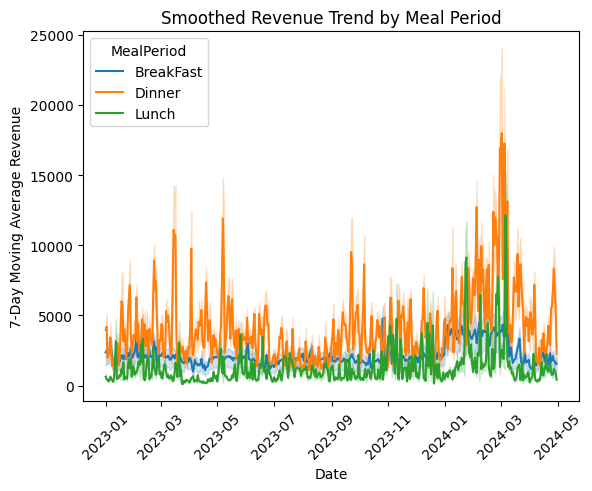

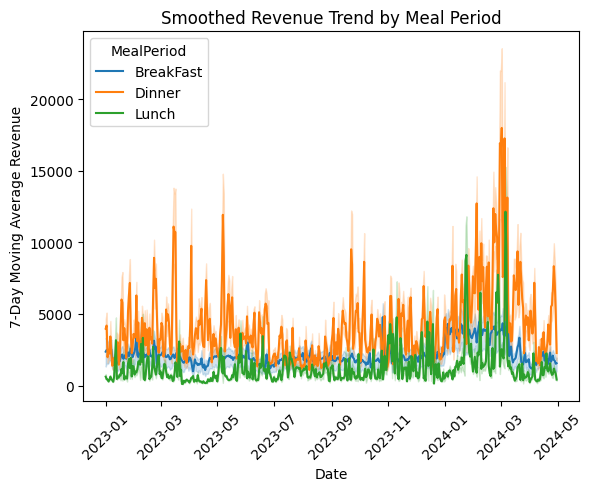

In [9]:
# Smooth revenue with 7-day moving average
smoothed = final_df.copy()
smoothed["TotalCheckAmount"] = smoothed.groupby("MealPeriod")["TotalCheckAmount"].transform(lambda x: x.rolling(7, min_periods=1).mean())

sns.lineplot(data=smoothed, x="Date", y="TotalCheckAmount", hue="MealPeriod")
plt.title("Smoothed Revenue Trend by Meal Period")
plt.ylabel("7-Day Moving Average Revenue")
plt.xticks(rotation=45)
plt.show()
# Smooth revenue with 7-day moving average
smoothed = final_df.copy()
smoothed["TotalCheckAmount"] = smoothed.groupby("MealPeriod")["TotalCheckAmount"].transform(lambda x: x.rolling(7, min_periods=1).mean())

sns.lineplot(data=smoothed, x="Date", y="TotalCheckAmount", hue="MealPeriod")
plt.title("Smoothed Revenue Trend by Meal Period")
plt.ylabel("7-Day Moving Average Revenue")
plt.xticks(rotation=45)
plt.show()


In [11]:
final_df['Date'] = pd.to_datetime(final_df['Date'])

# Sort and apply 7-day moving average per MealPeriod + RevenueCenterName
smoothed_df = (
    final_df.sort_values("Date")
    .groupby(["MealPeriod", "RevenueCenterName"], as_index=False)
    .apply(lambda x: x.assign(SmoothedRevenue=x["TotalCheckAmount"].rolling(7, min_periods=1).mean()))
    .reset_index(drop=True)
)


/tmp/ipykernel_93247/1164184104.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(SmoothedRevenue=x["TotalCheckAmount"].rolling(7, min_periods=1).mean()))


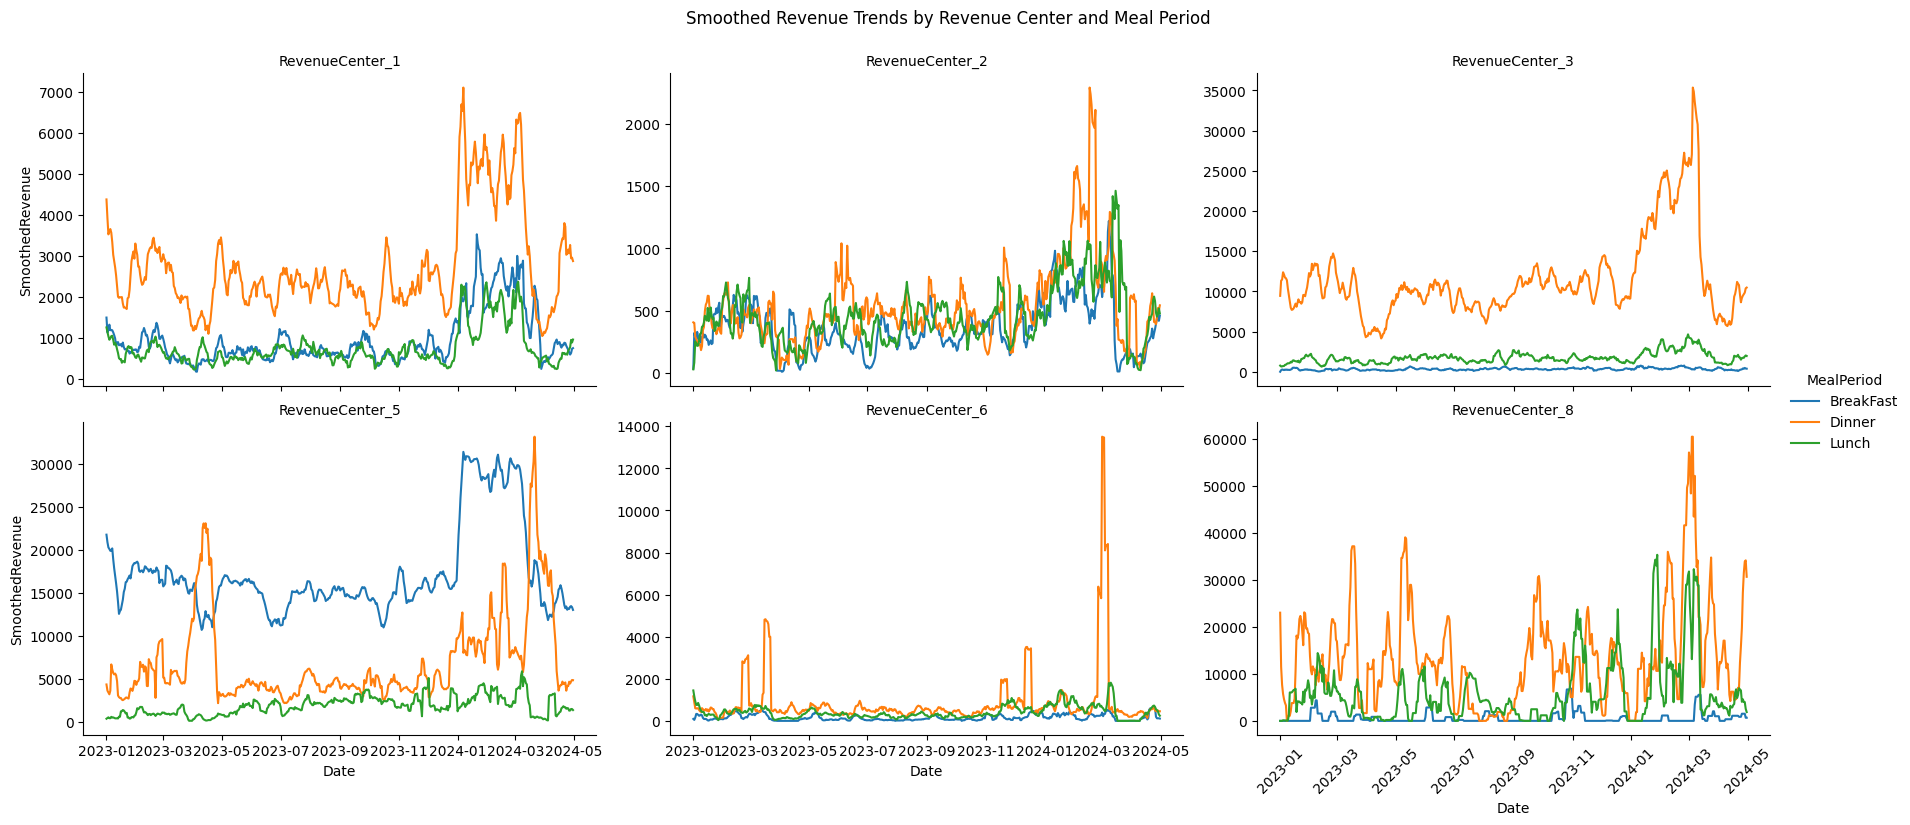

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot only active revenue centers (optional filter)
active_centers = smoothed_df.groupby("RevenueCenterName")["TotalCheckAmount"].sum().sort_values(ascending=False).head(6).index
filtered_df = smoothed_df[smoothed_df["RevenueCenterName"].isin(active_centers)]

g = sns.FacetGrid(
    filtered_df,
    col="RevenueCenterName",
    hue="MealPeriod",
    col_wrap=3,
    height=4,
    aspect=1.5,
    sharey=False
)

g.map(sns.lineplot, "Date", "SmoothedRevenue").add_legend()
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Smoothed Revenue Trends by Revenue Center and Meal Period")
plt.xticks(rotation=45)
plt.show()
